# Importar Librarias y datos

In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np   
import itertools

from scipy.stats import chi2_contingency, ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf 

In [163]:
df = pd.read_parquet("output_06.parquet")

In [164]:
df.head()

,age,gender,education,marital_status,race,is_hispanic,employment_commitment,employment_stat,wage_per_hour,working_week_per_year,...,household_stat,tax_status,gains,losses,stocks_status,citizenship,country_of_birth_own,migration_code_change_in_msa,migration_code_change_in_reg,income_above_limit
0,79,1,secondary_complete,Widowed,White,All other,Not in labor force,0,0,52,...,Householder,Head of household,0,0,292,Native,US,?,?,0
1,65,1,secondary_complete,Widowed,White,All other,Children or Armed Forces,0,0,0,...,Nonfamily Householder,Single,0,0,0,Native,US,unchanged,unchanged,0
2,21,0,secondary_incomplete,Never married,Black,All other,Children or Armed Forces,0,500,15,...,Child,Single,0,0,0,Native,US,unchanged,unchanged,0
4,70,0,secondary_complete,Married-civilian spouse present,White,All other,Not in labor force,0,0,0,...,Spouse,Joint both 65+,0,0,0,Native,US,?,?,0
5,45,0,university_graduate_or_higher,Married-civilian spouse present,Asian or Pacific Islander,All other,Children or Armed Forces,0,825,52,...,Householder,Joint both under 65,0,0,0,Foreign born- Not a citizen of U S,Other,unchanged,unchanged,0


# Normalización de datos

In [166]:
# Identificar columnas numéricas
columnas_numericas = df.select_dtypes(include=['int64', 'float64']).columns

In [167]:
columnas_numericas

Index(['age', 'gender', 'employment_stat', 'wage_per_hour',
       'working_week_per_year', 'occupation_code', 'total_employed', 'gains',
       'losses', 'stocks_status', 'income_above_limit'],
      dtype='object')

In [168]:
#Vemos que en algunas columnas hay mucha diferencia entre algunos valores y sería complicado compararlos
print(df[columnas_numericas].describe())

                 age         gender  employment_stat  wage_per_hour  \
count  159814.000000  159814.000000    159814.000000  159814.000000   
mean       43.079298       0.527882         0.231713      72.667351   
std        18.373909       0.499224         0.625998     314.889067   
min        15.000000       0.000000         0.000000       0.000000   
25%        29.000000       0.000000         0.000000       0.000000   
50%        40.000000       1.000000         0.000000       0.000000   
75%        56.000000       1.000000         0.000000       0.000000   
max        90.000000       1.000000         2.000000    9999.000000   

       working_week_per_year  occupation_code  total_employed          gains  \
count          159814.000000    159814.000000   159814.000000  159814.000000   
mean               30.358767        14.841578        2.564193     571.453358   
std                23.701096        14.895921        2.402856    5369.857726   
min                 0.000000         0.0

In [169]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])

In [170]:
# Ver estadísticas descriptivas de las columnas numéricas
print(df[columnas_numericas].describe())

                 age         gender  employment_stat  wage_per_hour  \
count  159814.000000  159814.000000    159814.000000  159814.000000   
mean        0.374391       0.527882         0.115857       0.007267   
std         0.244985       0.499224         0.312999       0.031492   
min         0.000000       0.000000         0.000000       0.000000   
25%         0.186667       0.000000         0.000000       0.000000   
50%         0.333333       1.000000         0.000000       0.000000   
75%         0.546667       1.000000         0.000000       0.000000   
max         1.000000       1.000000         1.000000       1.000000   

       working_week_per_year  occupation_code  total_employed          gains  \
count          159814.000000    159814.000000   159814.000000  159814.000000   
mean                0.583822         0.322643        0.427366       0.005715   
std                 0.455790         0.323824        0.400476       0.053699   
min                 0.000000         0.0

# Matriz de correlación

### Valores de correlación:

- Cercano a 1 → Correlación positiva fuerte (una sube, la otra también).
- Cercano a -1 → Correlación negativa fuerte (una sube, la otra baja).
- Cercano a 0 → No hay correlación.

In [173]:
# Crear la matriz de correlación 
matriz_correlacion = df[columnas_numericas].corr().round(2)

# Mostrar la matriz
matriz_correlacion

,age,gender,employment_stat,wage_per_hour,working_week_per_year,occupation_code,total_employed,gains,losses,stocks_status,income_above_limit
age,1.00,0.05,-0.17,-0.06,-0.26,-0.28,-0.28,0.03,0.01,0.09,0.05
gender,0.05,1.00,-0.05,-0.03,-0.17,-0.20,-0.09,-0.06,-0.08,-0.01,-0.19
employment_stat,-0.17,-0.05,1.00,0.04,0.21,0.17,0.18,0.01,0.01,-0.01,0.02
wage_per_hour,-0.06,-0.03,0.04,1.00,0.16,0.16,0.16,-0.00,0.01,-0.01,0.01
working_week_per_year,-0.26,-0.17,0.21,0.16,1.00,0.56,0.67,0.07,0.07,-0.02,0.22
occupation_code,-0.28,-0.20,0.17,0.16,0.56,1.00,0.40,-0.02,0.01,-0.06,-0.05
total_employed,-0.28,-0.09,0.18,0.16,0.67,0.40,1.00,0.04,0.05,-0.02,0.18
gains,0.03,-0.06,0.01,-0.00,0.07,-0.02,0.04,1.00,-0.02,0.13,0.24
losses,0.01,-0.08,0.01,0.01,0.07,0.01,0.05,-0.02,1.00,0.04,0.14
stocks_status,0.09,-0.01,-0.01,-0.01,-0.02,-0.06,-0.02,0.13,0.04,1.00,0.17


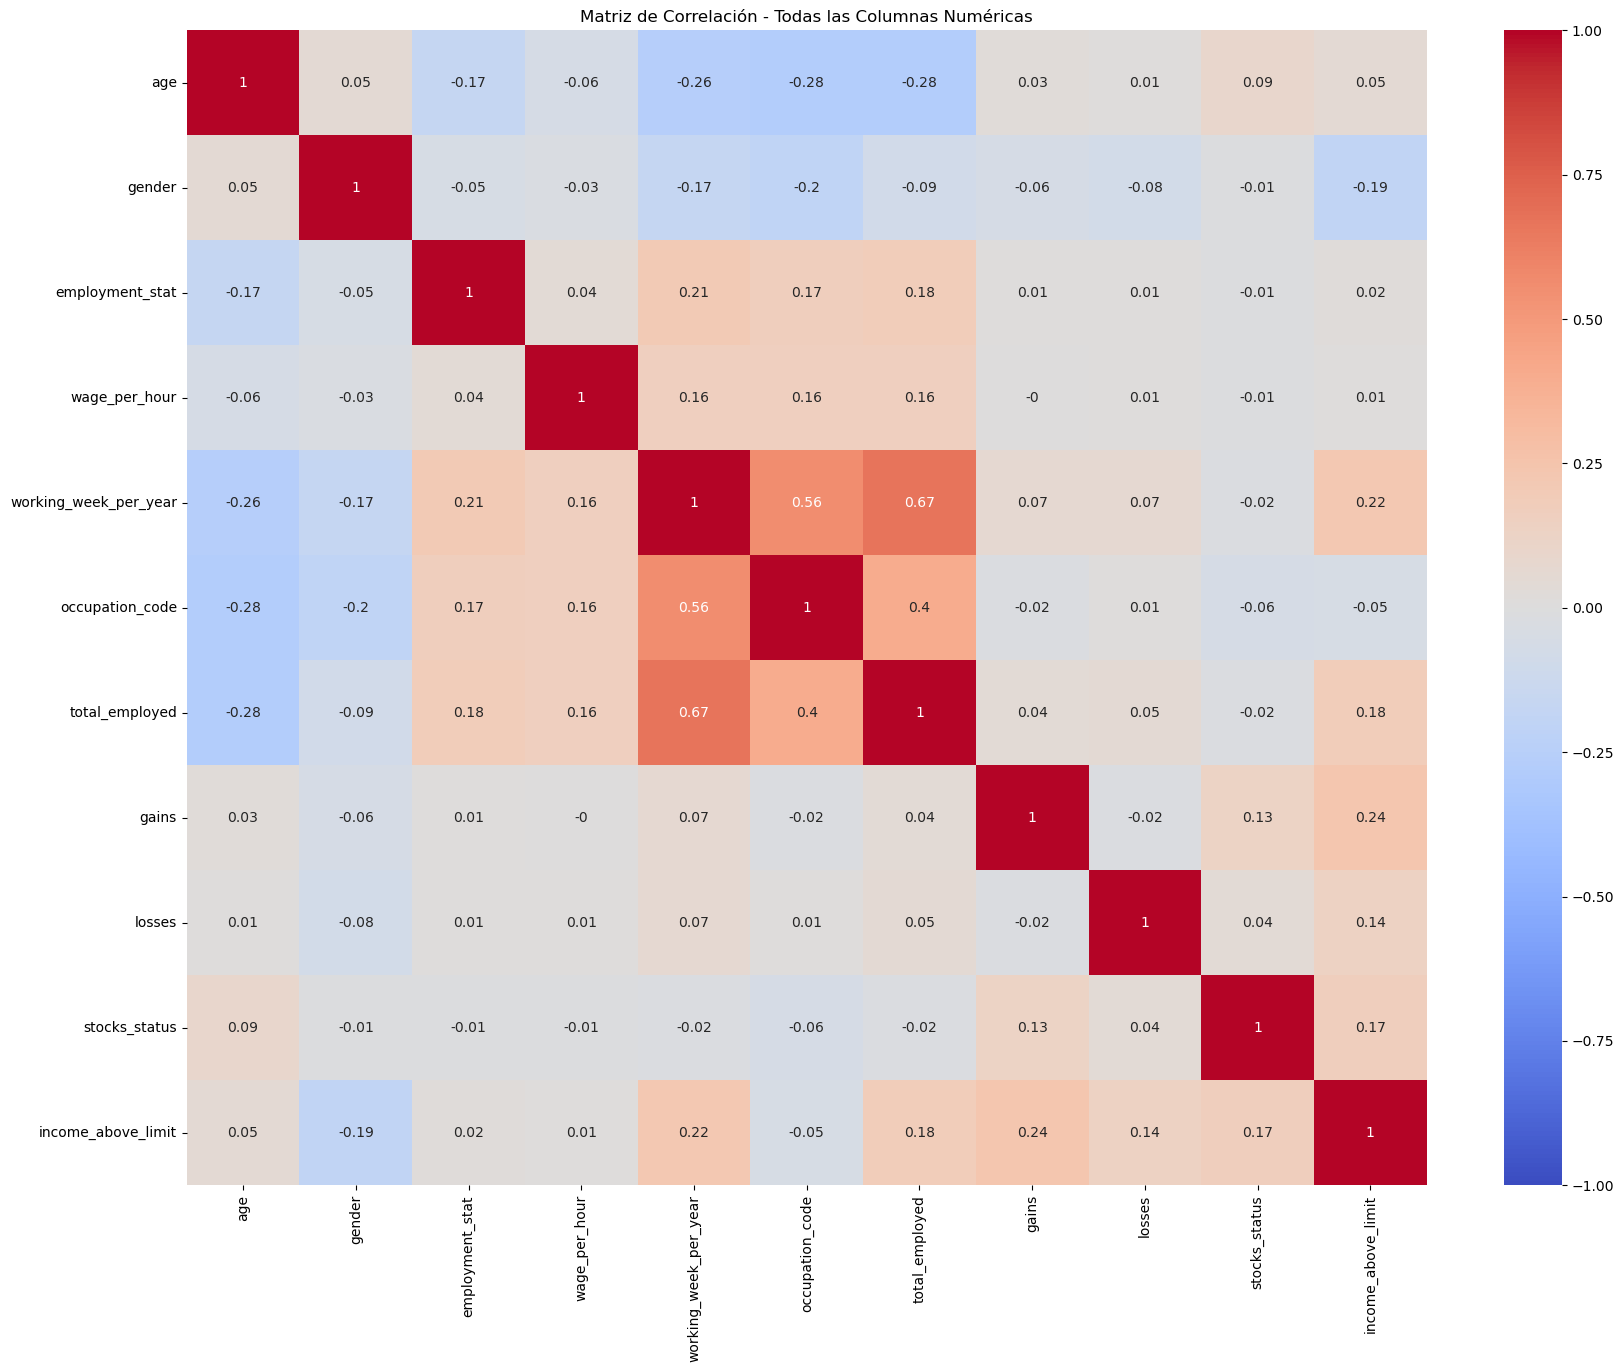

In [174]:
plt.figure(figsize = (20, 15))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm',vmin=-1, vmax=1)
plt.title("Matriz de Correlación - Todas las Columnas Numéricas")
plt.show()

In [175]:
filtro_gains = (matriz_correlacion["gains"] > 0.02) | (matriz_correlacion["gains"] < -0.02)
mas_relevantes_gains = matriz_correlacion.loc[filtro_gains, :]
mas_relevantes_gains

,age,gender,employment_stat,wage_per_hour,working_week_per_year,occupation_code,total_employed,gains,losses,stocks_status,income_above_limit
age,1.00,0.05,-0.17,-0.06,-0.26,-0.28,-0.28,0.03,0.01,0.09,0.05
gender,0.05,1.00,-0.05,-0.03,-0.17,-0.20,-0.09,-0.06,-0.08,-0.01,-0.19
working_week_per_year,-0.26,-0.17,0.21,0.16,1.00,0.56,0.67,0.07,0.07,-0.02,0.22
total_employed,-0.28,-0.09,0.18,0.16,0.67,0.40,1.00,0.04,0.05,-0.02,0.18
gains,0.03,-0.06,0.01,-0.00,0.07,-0.02,0.04,1.00,-0.02,0.13,0.24
stocks_status,0.09,-0.01,-0.01,-0.01,-0.02,-0.06,-0.02,0.13,0.04,1.00,0.17
income_above_limit,0.05,-0.19,0.02,0.01,0.22,-0.05,0.18,0.24,0.14,0.17,1.00


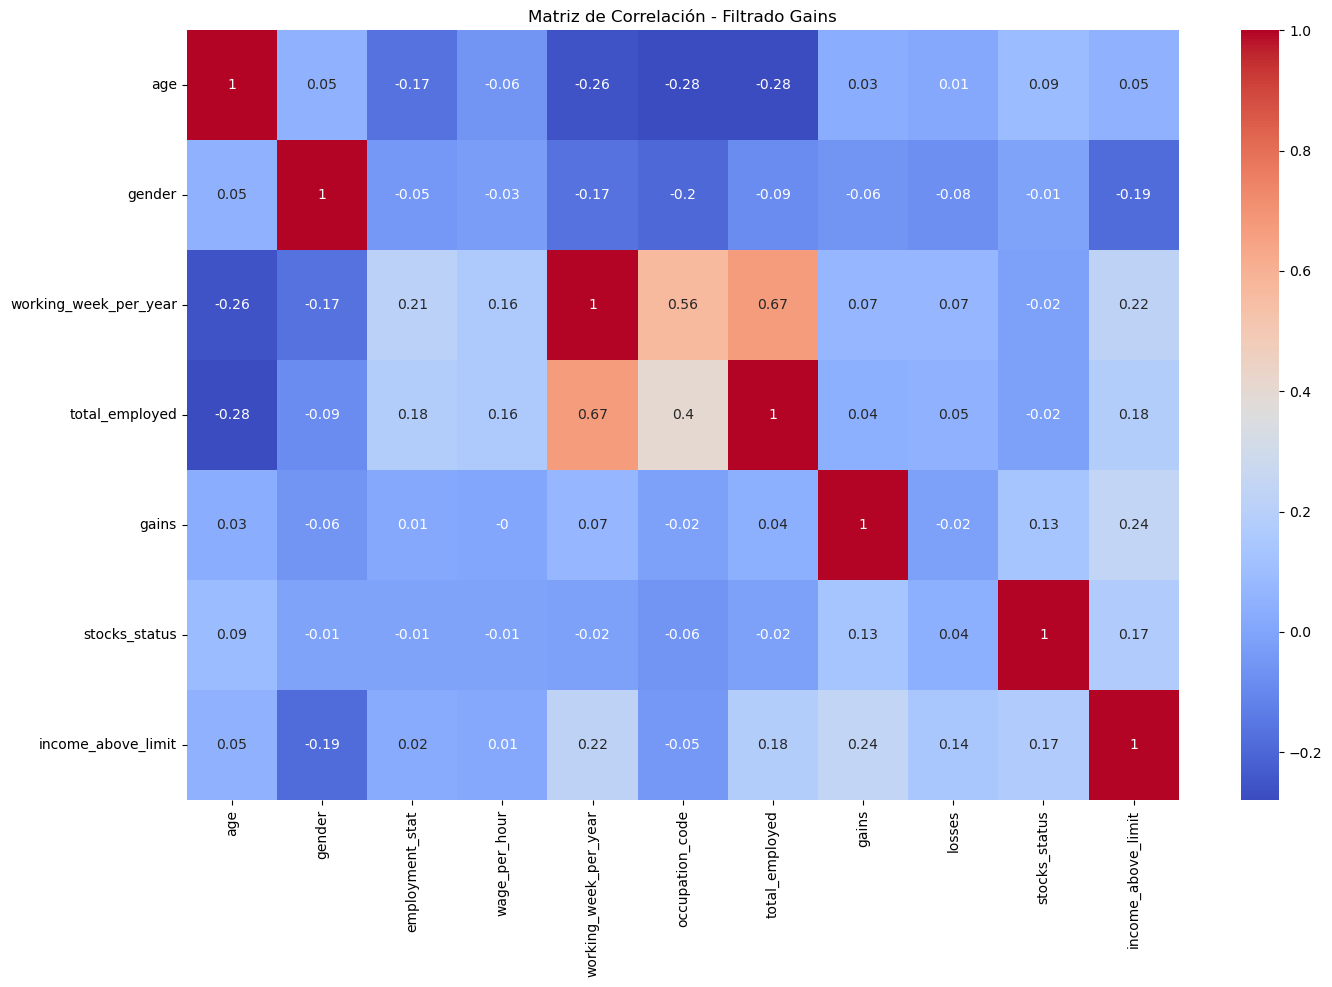

In [176]:
plt.figure(figsize=(16, 10))
sns.heatmap(mas_relevantes_gains, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación - Filtrado Gains")
plt.show()

In [177]:

filtro_losses = (matriz_correlacion["losses"] > 0.02) | (matriz_correlacion["losses"] < -0.02)
mas_relevantes_losses = matriz_correlacion.loc[filtro_losses, :]
mas_relevantes_losses


,age,gender,employment_stat,wage_per_hour,working_week_per_year,occupation_code,total_employed,gains,losses,stocks_status,income_above_limit
gender,0.05,1.00,-0.05,-0.03,-0.17,-0.20,-0.09,-0.06,-0.08,-0.01,-0.19
working_week_per_year,-0.26,-0.17,0.21,0.16,1.00,0.56,0.67,0.07,0.07,-0.02,0.22
total_employed,-0.28,-0.09,0.18,0.16,0.67,0.40,1.00,0.04,0.05,-0.02,0.18
losses,0.01,-0.08,0.01,0.01,0.07,0.01,0.05,-0.02,1.00,0.04,0.14
stocks_status,0.09,-0.01,-0.01,-0.01,-0.02,-0.06,-0.02,0.13,0.04,1.00,0.17
income_above_limit,0.05,-0.19,0.02,0.01,0.22,-0.05,0.18,0.24,0.14,0.17,1.00


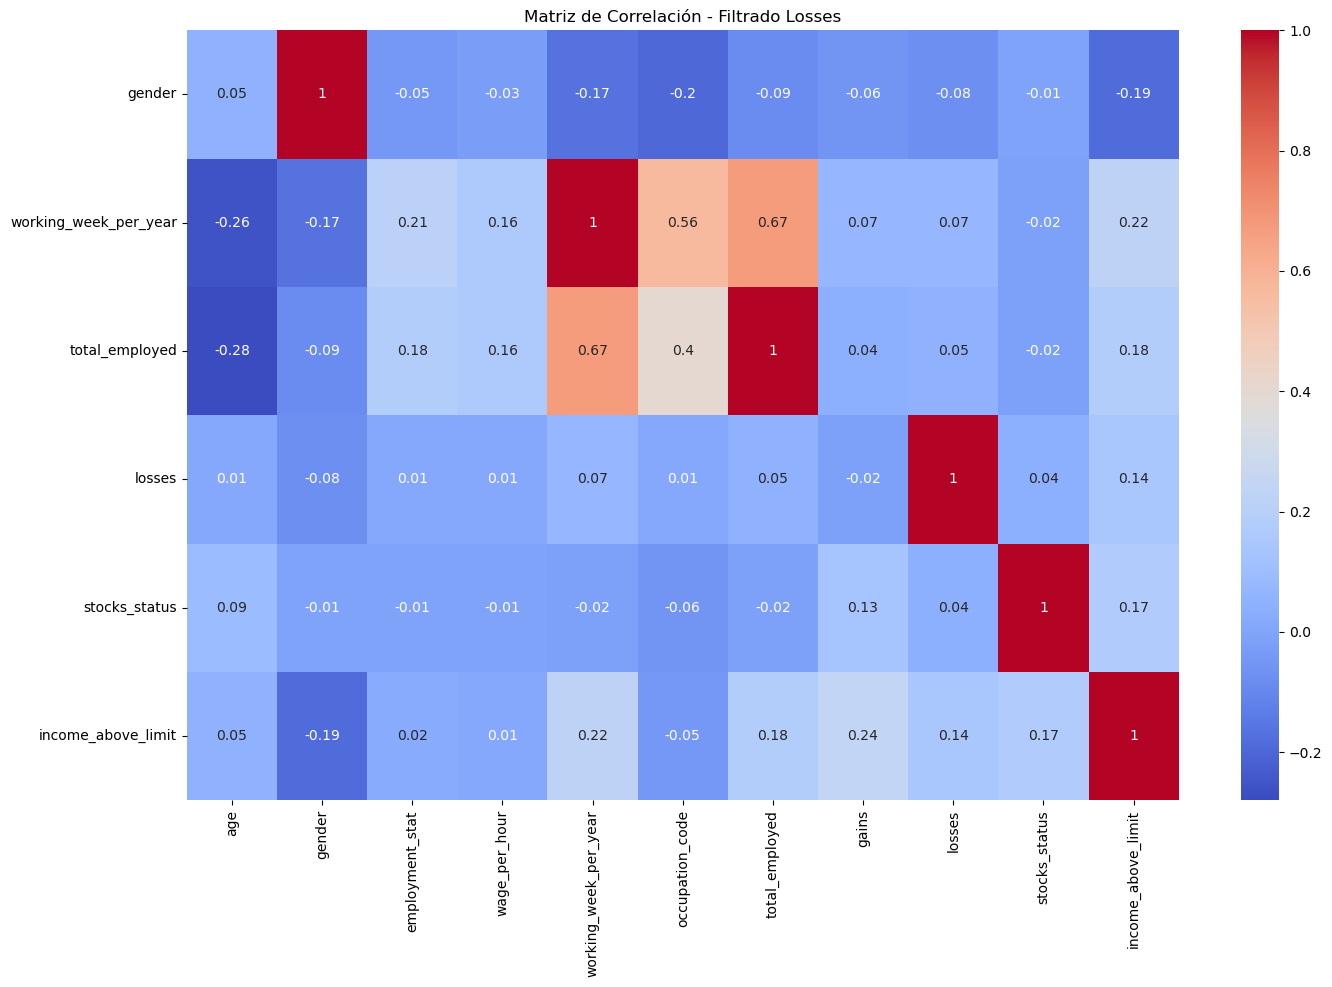

In [178]:

plt.figure(figsize=(16, 10))
sns.heatmap(mas_relevantes_losses, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación - Filtrado Losses")
plt.show()


# Guardar output

In [180]:
df.to_parquet("output_07.parquet")